<a href="https://colab.research.google.com/github/Aquiles07/Actividades_Curso/blob/main/01_MLP_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/notebooks/01-MLP-Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Conectar la notebook en modo GPU

Entorno de ejecución → Cambiar tipo de entorno de ejecución

Algunas consideraciones:

* No dejar la notebook conectada sin actividad ya que Colab penaliza esto al asignar un entorno con GPU.
* No pedir el entorno con GPU si no se va a usar.

Recuerda la simbología de las secciones:

* 🔽 Esta sección no forma parte del proceso usual de Machine Learning. Es una exploración didáctica de algún aspecto del funcionamiento del algoritmo.
* ⚡ Esta sección incluye técnicas más avanzadas destinadas a optimizar o profundizar en el uso de los algoritmos.
* ⭕ Esta sección contiene un ejercicio o práctica a realizar. Aún si no se establece una fecha de entrega, es muy recomendable realizarla para practicar conceptos clave de cada tema.

# Redes Neuronales MLP para clasificación

<img align="center" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/mlp.png?raw=1"/>

En esta notebook usaremos una red neuronal de tipo **MultiLayer Perceptron (MLP)** para el problema de clasificación en el dataset MNIST.

Al final, practicaremos el uso de estas redes para buscar un mejor modelo para esta tarea.

Benchmarks para el dataset MNIST

1. **No Routing Needed Between Capsules**, 2020. *Accuracy: 99.87%*

    Modelo de redes CNN con Homogeneous Vector Capsules (HVCs) que modifican el flujo de datos entre capas. [Artículo](https://arxiv.org/abs/2001.09136), [código](https://github.com/AdamByerly/BMCNNwHFCs).

2. **An Ensemble of Simple Convolutional Neural Network Models for MNIST Digit Recognition**, 2020. *Accuracy: 99.87%*

    Modelo de ensamble de redes CNN [Artículo](https://arxiv.org/abs/2008.10400), [código](https://github.com/ansh941/MnistSimpleCNN).

## 1. El conjunto de datos

Observar que, ahora sí, usamos todo el conjunto de datos completo.

In [ ]:
import numpy as np
from keras.datasets import mnist

# Load MNIST handwritten digit data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

y_test_original = y_test.copy()  # Hacemos una copia del 'y_test', la usaremos al final

11490434/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Visualizamos 6 ejemplos aleatorios, junto con sus etiquetas

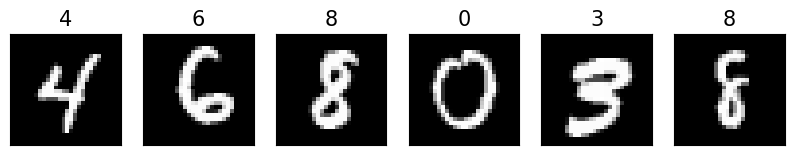

In [ ]:
import matplotlib.pyplot as plt

# ------ Obtenemos algunos índices aleatorios:
some_idxs = np.random.choice(list(range(y_train.shape[0])),size=6,replace=False)

fig, axes = plt.subplots(ncols=6, sharex=False,
			 sharey=True, figsize=(10, 4))
for i,idx in enumerate(some_idxs):
	axes[i].set_title(y_train[idx],fontsize=15)
	axes[i].imshow(X_train[idx], cmap='gray')
	axes[i].get_xaxis().set_visible(False)
	axes[i].get_yaxis().set_visible(False)
plt.show()

## Definiendo la red

### Etiqueta de clase vs Vector de clase

**IMPORTANTE❗**

Al usar redes neuronales, usalmente el vector de etiquetas debe estar codificado como vectores **one-hot**. Es decir:

$$1 → (1,0,...,0) $$
$$2 → (0,1,...,0) $$
$$ ... $$

Entonces, las etiquetas $y$ son matrices de tamaño $N\times m$ donde

* $N$: número de instancias
* $m$: número de clases

Hacemos la codificación usando la función [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) de [keras](https://www.tensorflow.org/guide/keras).

⚠ A lo largo de las versiones, a veces cambia de ubicación este tipo de funciones.

$$y_j \overset{\text{to_categorical}}{\rightarrow} (0,...,0,\overset{j}{1},0,...,0)$$

$$y_j \overset{\text{numpy.argmax}}{\leftarrow} (0,...,0,\overset{j}{1},0,...,0)$$



In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.utils import to_categorical

print("---------- Antes de la codificación ----------")
print(f"Primeras 5 etiquetas: {y_train[:5]}")
print(f"Shape: {y_train.shape}")

y_train = to_categorical(y_train,num_classes=10)

print("---------- Después de la codificación ----------")
print(f"Primeras 5 etiquetas:\n{y_train[:5]}\n")
print(f"Shape: {y_train.shape}")

y_test = to_categorical(y_test,num_classes=10)

---------- Antes de la codificación ----------
Primeras 5 etiquetas: [5 0 4 1 9]
Shape: (60000,)
---------- Después de la codificación ----------
Primeras 5 etiquetas:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

Shape: (60000, 10)


### Ingredientes de una arquitectura

Hay dos principales maneras de definir modelos en Keras:

* [**Sequential**](https://keras.io/api/models/sequential/): Un modelo es una secuencia lineal de *layers*. Es sencilla de implementar pero no muy flexible.

<img align="center" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/keras-sequential.png?raw=1"/>

* [**Model**](https://www.tensorflow.org/api_docs/python/tf/keras/Model): Un modelo se especifica mediante una estructura similar a un *grafo*, indicando conexiones entre *layers*. Es muy flexible.

<img align="center" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/keras-model.png?raw=1"/>

In [ ]:
from keras.models import Sequential

Por ahora, usaremos dos tipos básicos de capas:

* [**Dense**](https://keras.io/api/layers/core_layers/dense/): implementa la operación:
$$\text{output} = \text{activation}(\text{input}\cdot\text{weights} + \text{bias})$$
donde `activation` es la función de activación y bias es un vector de sesgo creado por la capa (sólo aplicable si `use_bias` es True). Es una capa **densa** por lo que cada neurona de esta capa se conecta con cada una de las neuronas de la capa anterior.
* [**Flatten**](https://keras.io/api/layers/reshaping_layers/flatten/): Aplana los datos para tener un arreglo unidimensional.

In [ ]:
from keras.layers import Dense, Flatten

Definimos ahora la arquitectura de la red neuronal MLP. Observa los siguientes elementos:

* La **función de activación** de cada capa, [documentación](https://keras.io/api/layers/activations/).
* La **función de perdida** de la red, es la función de costo que mide que tanto error hay en las predicciones. El optimizador minimizará está función, [documentación](https://keras.io/api/losses/).
* El **optimizador** es la clase que minimizará la función de perdida. De su elección depende qué tan rápido converjamos a una solución, [documentación](https://keras.io/api/optimizers/)
* La(s) **métrica(s) de desempeño** a monitorear durante el entrenamiento, tanto en el conjunto de entrenamiento como en el de validación. Además, podemos evaluar las métricas usuales al generar las predicciones. [Documentación](https://keras.io/api/metrics/)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(28,28))) # Tenemos que aplanar las matrices representando a cada imagen, las capas densas sólo funcionan con vectores de entrada
model.add(Dense(8, activation='tanh'))
model.add(Dense(10, activation='softmax'))  # Cuando se trata de tareas de clasificación multiclase, ponemos una activación softmax en la capa de salida

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


El método `summary()` de un modelo de Keras (ya sea `Sequential` o `Model`) imprime información importante del modelo. [Documentación](https://keras.io/api/models/model/).

El siguiente paso es compilar el modelo. Esto lo hacemos con el método [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

⚠ Es necesario compilar cada que vamos a volver a entrenar. Esto resetea los pesos.

In [ ]:
model.compile(loss='categorical_crossentropy',
	      optimizer='adam',
	      metrics=['acc']
		  )

## ⚡ Visualizando la arquitectura de la red

A continuación se presentan dos maneras adicionales de visualizar la arquitectura de la red. Hay estrategias que producen efectos más atractivos, puedes buscar por tu cuenta.

### 1. Usando visualkeras

In [ ]:
!pip install -q visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.2 MB/s eta 0:00:00


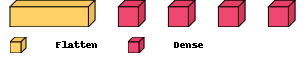

In [ ]:
from visualkeras import layered_view

layered_view(model,
            legend=True,draw_funnel=False,
            draw_volume=True,spacing=30)

Podemos agregar más detalles, como los colores

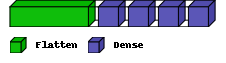

In [ ]:
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Dense]['fill'] = '#5b56b7'
color_map[Flatten]['fill'] = '#0fbe0b'
layered_view(model, legend=True,color_map=color_map)

### Usando [`plot_model`](https://keras.io/api/utils/model_plotting_utils/) de keras

El `None` en el shape de las entradas y salidas se refiere a que no tiene esa información, son los ejemplos que pasan al *mismo tiempo*.

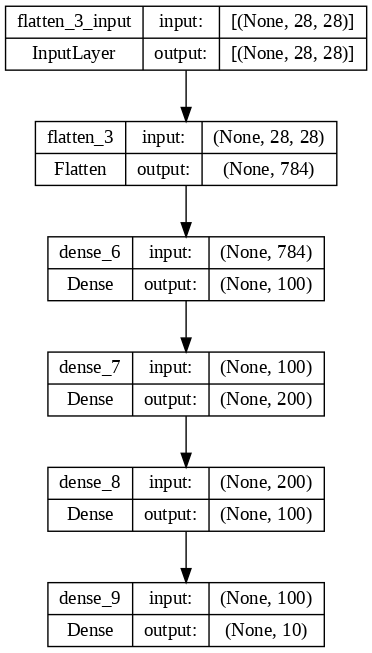

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True,
           show_layer_names=True, dpi=100)

## Entrenando la red

Entrenamos la red con el método [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), la mécanica es la misma que en los métodos de ML clásico.

Algunas diferencias son:

* Especificar el número de épocas. Entre más épocas, más puede aprender el módelo, aunque hay más riesgo de overfitting.

* Especificar el conjunto de validación, además del conjunto de entrenamiento. Este sirve para proporcionar un indicador no sesgado del desempeño del modelo. Se puede hacer especificamente, o como una fracción del conjunto de entrenamiento.

<img align="left" width="50%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/training-validation-test.png?raw=1"/>





Observa las métricas y pérdida en el conjunto de entrenamiento y validación.

El entrenamiento regresa un objeto de tipo `History`. Su atributo History.history es un registro de valores de pérdidas de entrenamiento y valores de métricas en épocas sucesivas, así como valores de pérdidas de validación y valores de métricas de validación (si procede).

In [ ]:
n_epocas = 8

history = model.fit(X_train, y_train, epochs=n_epocas, validation_data=(X_test,y_test))

Epoch 1/8
1875/1875 [==============================] - 14s 6ms/step - loss: 1.4602 - acc: 0.5215 - val_loss: 1.1956 - val_acc: 0.5945
Epoch 2/8
1875/1875 [==============================] - 13s 7ms/step - loss: 0.9298 - acc: 0.7019 - val_loss: 0.8092 - val_acc: 0.7413
Epoch 3/8
1875/1875 [==============================] - 12s 7ms/step - loss: 0.7765 - acc: 0.7588 - val_loss: 0.7273 - val_acc: 0.7705
Epoch 4/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7517 - acc: 0.7684 - val_loss: 0.7252 - val_acc: 0.7867
Epoch 5/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6857 - acc: 0.7985 - val_loss: 0.6802 - val_acc: 0.8053
Epoch 6/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6486 - acc: 0.8000 - val_loss: 0.6692 - val_acc: 0.7957
Epoch 7/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6224 - acc: 0.8123 - val_loss: 0.6290 - val_acc: 0.7989
Epoch 8/8
1875/1875 [==============================] - 6s 3ms/step

Graficamos la función de perdida en cada época, tanto en el conjunto de entrenamiento, como en el de validación.

Estas se llaman **gráficas de entrenamiento**. Son muy importantes para evaluar si hay overfitting, entre otras cosas.

Observa que los registros *históricos* del entrenamiento (perdidas y métricas) se encuentran en el diccionario `history.history` especificado anteriormente.

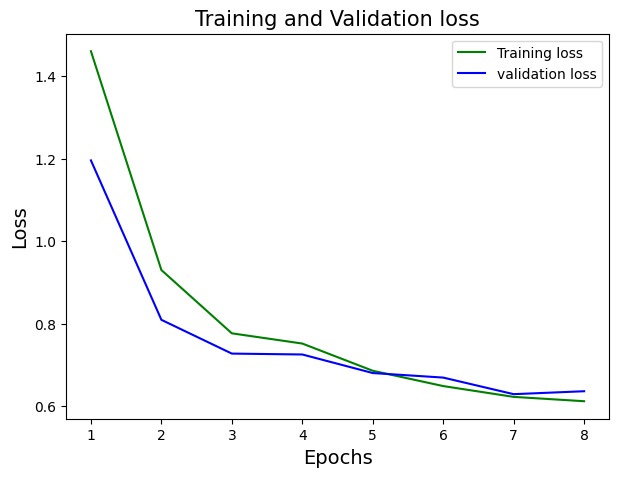

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1,n_epocas+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend()
plt.show()

Ahora, graficamos el accuracy a lo largo del entrenamiento, tanto en el conjunto de entrenamiento como en el validación.

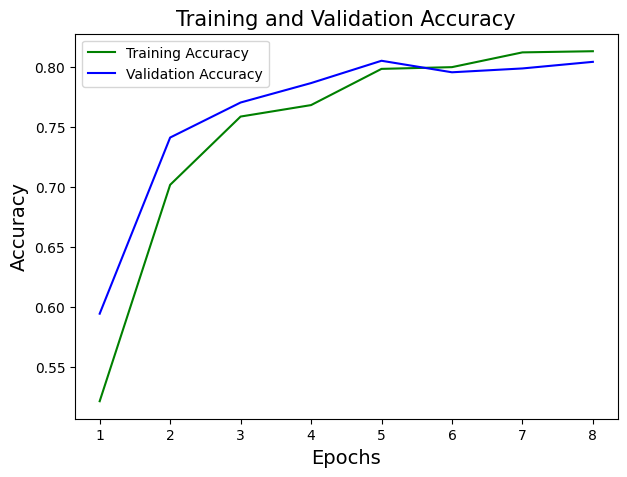

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']

epochs = range(1,n_epocas+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(epochs)
plt.legend()
plt.show()

🔽 De la siguiente forma podemos acceder a la matriz de pesos y sesgos en cada capa. Las guardamos como arreglos de numpy. Son los pesos usados en la notebook anterior.

In [ ]:
first_layer_weights = model.layers[1].get_weights()[0]
first_layer_biases  = model.layers[1].get_weights()[1]

np.save("mnist_weights1.npy",first_layer_weights)
np.save("mnist_biases1.npy",first_layer_biases)

In [ ]:
second_layer_weights = model.layers[2].get_weights()[0]
second_layer_biases  = model.layers[2].get_weights()[1]

np.save("mnist_weights2.npy",second_layer_weights)
np.save("mnist_biases2.npy",second_layer_biases)

## Predicciones y rendimiento

¿Cómo se ven las predicciones?

🔽 Aquí sólo estamos realizando la predicción de la clase de un solo elemento, con fines ilustrativos.

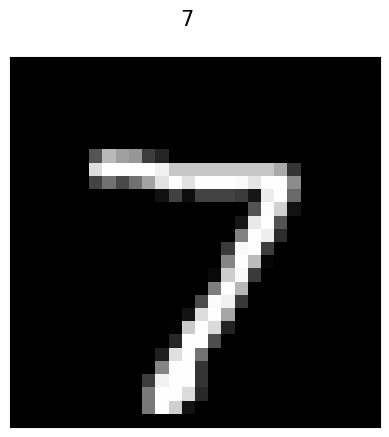

1/1 [==============================] - 0s 185ms/step

Salida de la red neuronal para este primer elemento:
 [[0.    0.    0.003 0.026 0.    0.001 0.    0.94  0.003 0.026]]

Son probabilidades, la suma de las entradas es 0.9999999403953552

Tomamos el índice de la entrada con mayor probabilidad: [7]


In [ ]:
x = X_test[0].copy()

# ----- Graficamos este primer ejemplo de prueba:
plt.figure()
plt.suptitle(y_test_original[0],fontsize=15)
plt.imshow(x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

# ----- Cambiamos a la forma adecuada para entrar a la red neuronal:
x_input = x.reshape(-1,x.shape[0],x.shape[1])

# ----- Lo pasamos por la red neuronal ya entrenada:
prediction = model.predict(x_input)
print(f"\nSalida de la red neuronal para este primer elemento:\n {np.round(prediction,3)}\n")

print(f"Son probabilidades, la suma de las entradas es {np.sum(prediction)}")

# ----- Tomamos el argmax:
prediction = np.argmax(prediction, axis=1)
print(f"\nTomamos el índice de la entrada con mayor probabilidad: {prediction}")

**Obtenemos todas las predicciones sobre el conjunto de prueba.**

Observa que el modelo de keras también tiene el método [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)

In [ ]:
predictions_matrix = model.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)  # Prueba a comentar esta línea y discutamos qué pasa

313/313 [==============================] - 1s 3ms/step


Visualizamos algunas predicciones

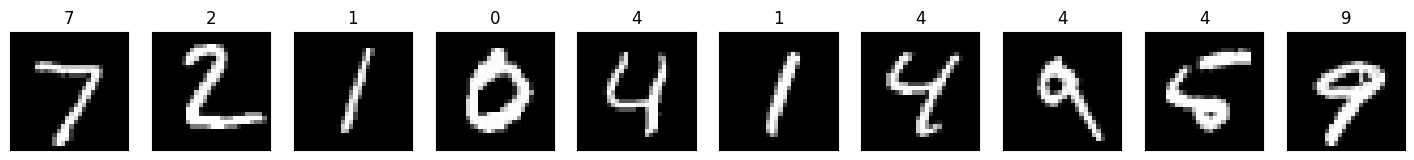

In [ ]:
fig, axes = plt.subplots(ncols=10, sharex=False,
			 sharey=True, figsize=(18, 4))
for i in range(10):
	axes[i].set_title(predictions[i])
	axes[i].imshow(X_test[i], cmap='gray')
	axes[i].get_xaxis().set_visible(False)
	axes[i].get_yaxis().set_visible(False)
plt.show()

Obtenemos las métricas de desempeño de la tarea de clasificación. Observar que ambas son **vectores** de etiquetas

In [ ]:
print(predictions.shape)
print(y_test_original.shape)

(10000,)
(10000,)


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

Test Accuracy: 0.8044
Test Recall: 0.7997646813795692
Test Precision: 0.8089444646010355


Recordemos el desempeño de los algoritmos clásicos de ML en este dataset:

<img align="left" width="30%" src="https://github.com/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/img/ML-MNIST.png?raw=1"/>

Calculamos el roc-auc score

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"Shape de y_test: {y_test.shape}")
print(f"Shape de las predicciones para el conjunto de prueba: {predictions_matrix.shape}")

roc_auc_score(y_test,predictions_matrix)

Shape de y_test: (10000, 10)


NameError: name 'predictions_matrix' is not defined

Mostramos la matriz de confusión

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
  plt.figure(dpi=120)
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  new_xticks =  [str(int(x.get_text())+1) for x in hmap.xaxis.get_ticklabels()]
  new_yticks =  [str(int(x.get_text())+1) for x in hmap.yaxis.get_ticklabels()]
  hmap.xaxis.set_ticklabels(new_xticks, rotation=0, ha='right')
  hmap.yaxis.set_ticklabels(new_yticks, rotation=0, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

cm = confusion_matrix(y_test_original,predictions)
show_confusion_matrix(cm)

NameError: name 'y_test_original' is not defined

⭕ ¿Qué dígitos son los que más confunde la red?

---

## ⭕ Práctica y Ejercicios

Implementa las siguientes redes neuronales de tipo MLP:

* 1 capa oculta de 200 neuronas sin activación. Entrena durante 30 épocas.
* 1 capa oculta de 200 neuronas con activación $tanh$. Entrena durante 30 épocas.
* 3 capas ocultas de 100, 200 y 100 neuronas respectivamente, todas con activación ReLU. Entrena durante 50 épocas.

En cada uno de los experimentos determina las especificaciones de las capas de entrada y salida. Además, en cada caso, reporta el accuracy y recall en el conjunto de prueba, así como las curvas de entrenamiento (perdida y accuracy).

* Con el objetivo de subir la métrica de accuracy en el conjunto de prueba, entrena un nuevo módelo de red neuronal MLP cambiando los siguientes hiperparámetros:

 * Número de capas ocultas.
 * Número de neuronas en cada capa oculta.
 * Función de activación de cada capa oculta.
 * Optimizador ([opciones](https://keras.io/api/optimizers/)).


---


Como referencia, el mejor resultado hasta ahora, sin usar redes convolucionales, es un accuracy de 99.65% (https://arxiv.org/abs/1003.0358)

Lista de resultados: http://yann.lecun.com/exdb/mnist/, https://paperswithcode.com/sota/image-classification-on-mnist

**Ejercicio 1:**

**1 capa oculta de 200 neuronas sin activación. Entrena durante 30 épocas.**

In [ ]:
import numpy as np
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [ ]:
print("---------- Antes de la codificación ----------")
print(f"Primeras 5 etiquetas: {y_train[:5]}")
print(f"Shape: {y_train.shape}")

y_train = to_categorical(y_train, num_classes=10)

print("---------- Después de la codificación ----------")
print(f"Primeras 5 etiquetas:\n{y_train[:5]}\n")
print(f"Shape: {y_train.shape}")

y_test = to_categorical(y_test, num_classes=10)

---------- Antes de la codificación ----------
Primeras 5 etiquetas: [5 0 4 1 9]
Shape: (60000,)
---------- Después de la codificación ----------
Primeras 5 etiquetas:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

Shape: (60000, 10)


In [ ]:
model_1 = Sequential()
model_1.add(Flatten(input_shape=(28, 28)))  # Aplanar las imágenes
model_1.add(Dense(200))  # Capa oculta de 200 neuronas sin activación
model_1.add(Dense(10, activation='softmax'))  # Capa de salida con activación softmax


In [ ]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
n_epocas_1 = 30
history_1 = model_1.fit(X_train, y_train, epochs=n_epocas_1, batch_size=32, validation_split=0.2) # store the fit history



Epoch 1/30
1500/1500 [==============================] - 10s 6ms/step - loss: 19.3148 - accuracy: 0.8494 - val_loss: 7.9471 - val_accuracy: 0.8932
Epoch 2/30
1500/1500 [==============================] - 7s 5ms/step - loss: 5.1762 - accuracy: 0.8727 - val_loss: 2.7016 - val_accuracy: 0.8723
Epoch 3/30
1500/1500 [==============================] - 8s 5ms/step - loss: 2.0369 - accuracy: 0.8592 - val_loss: 2.0147 - val_accuracy: 0.8547
Epoch 4/30
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7614 - accuracy: 0.8485 - val_loss: 2.1224 - val_accuracy: 0.8339
Epoch 5/30
1500/1500 [==============================] - 7s 5ms/step - loss: 1.7874 - accuracy: 0.8477 - val_loss: 1.7064 - val_accuracy: 0.8465
Epoch 6/30
1500/1500 [==============================] - 8s 6ms/step - loss: 1.7824 - accuracy: 0.8518 - val_loss: 1.7254 - val_accuracy: 0.8641
Epoch 7/30
1500/1500 [==============================] - 8s 5ms/step - loss: 1.7867 - accuracy: 0.8586 - val_loss: 1.7045 - val_accurac

**gráficas de entrenamiento.**

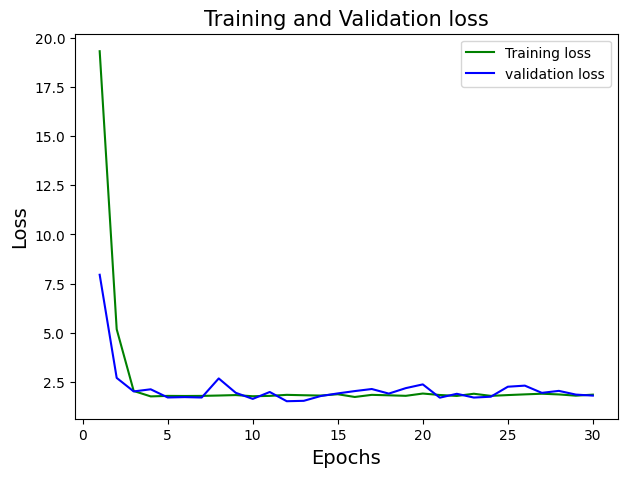

In [ ]:
loss_train = history_1.history['loss']
loss_val = history_1.history['val_loss']

epochs = range(1,n_epocas_1+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend()
plt.show()

**Gráfica Accuracy**

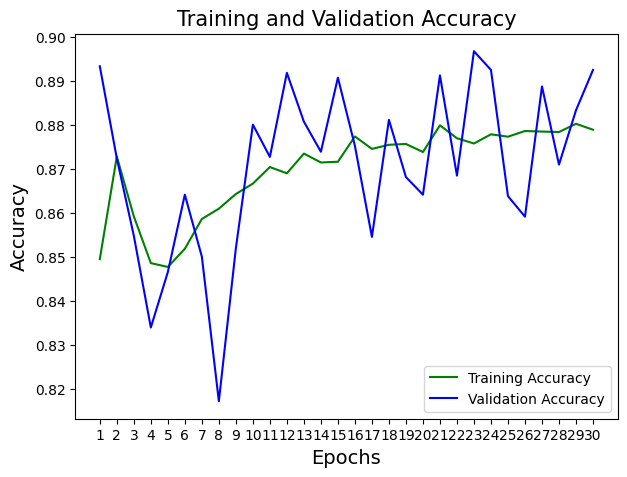

In [ ]:
loss_train = history_1.history['accuracy']
loss_val = history_1.history['val_accuracy']

epochs = range(1,n_epocas_1+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(epochs)
plt.legend()
plt.show()

In [ ]:
predictions_matrix = model_1.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)

313/313 [==============================] - 2s 7ms/step


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

Test Accuracy: 0.8877
Test Recall: 0.887092101654009
Test Precision: 0.8894535418657199


**Ejercicio 2:**

**1 capa oculta de 200 neuronas con activación tanh. Entrena durante 30 épocas.**

In [ ]:
model_2 = Sequential()
model_2.add(Flatten(input_shape=(28, 28)))  # Aplanar las imágenes
model_2.add(Dense(200, activation='tanh'))  # Capa oculta de 200 neuronas con activación tanh
model_2.add(Dense(10, activation='softmax'))

In [ ]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
n_epocas_2 = 30
history_2 = model_2.fit(X_train, y_train, epochs=n_epocas_2, batch_size=32, validation_split=0.2) # store the fit history

Epoch 1/30
1500/1500 [==============================] - 17s 11ms/step - loss: 0.5757 - accuracy: 0.8260 - val_loss: 0.4018 - val_accuracy: 0.8816
Epoch 2/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4115 - accuracy: 0.8760 - val_loss: 0.4117 - val_accuracy: 0.8699
Epoch 3/30
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3899 - accuracy: 0.8796 - val_loss: 0.3326 - val_accuracy: 0.9008
Epoch 4/30
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3662 - accuracy: 0.8896 - val_loss: 0.3351 - val_accuracy: 0.9009
Epoch 5/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3477 - accuracy: 0.8931 - val_loss: 0.3175 - val_accuracy: 0.9031
Epoch 6/30
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3339 - accuracy: 0.8973 - val_loss: 0.3115 - val_accuracy: 0.9072
Epoch 7/30
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3276 - accuracy: 0.8997 - val_loss: 0.3057 - val_accurac

**gráficas de entrenamiento.**

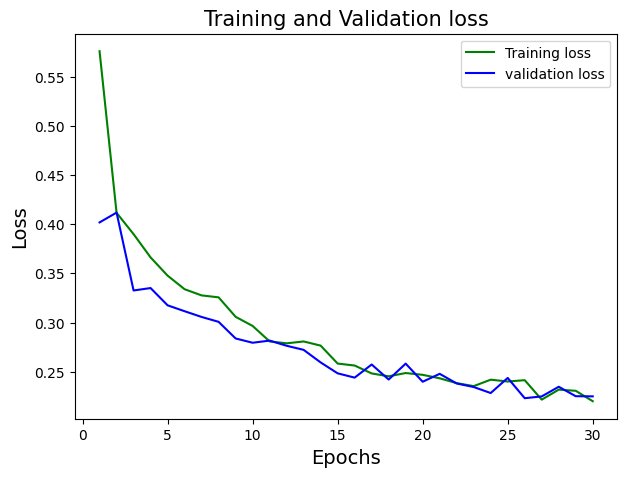

In [ ]:
loss_train = history_2.history['loss']
loss_val = history_2.history['val_loss']

epochs = range(1,n_epocas_2+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend()
plt.show()

**Gráfica de accuracy**

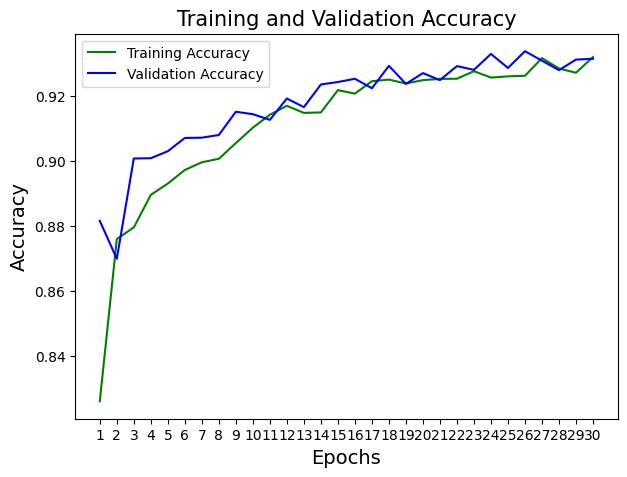

In [ ]:
loss_train = history_2.history['accuracy']
loss_val = history_2.history['val_accuracy']

epochs = range(1,n_epocas_2+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(epochs)
plt.legend()
plt.show()

In [ ]:
predictions_matrix = model_2.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)

313/313 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

Test Accuracy: 0.932
Test Recall: 0.9313651178930824
Test Precision: 0.9318919358501423


**Ejercicio 3:**

**3 capas ocultas de 100, 200 y 100 neuronas respectivamente, todas con activación ReLU. Entrena durante 50 épocas.**

In [ ]:
model_3 = Sequential()
model_3.add(Flatten(input_shape=(28, 28)))  # Aplanar las imágenes
model_3.add(Dense(100, activation='relu'))  # Primera capa oculta con 100 neuronas y activación ReLU
model_3.add(Dense(200, activation='relu'))  # Segunda capa oculta con 200 neuronas y activación ReLU
model_3.add(Dense(100, activation='relu'))  # Tercera capa oculta con 100 neuronas y activación ReLU
model_3.add(Dense(10, activation='softmax'))

In [ ]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
n_epocas_3 = 50
history_3 = model_3.fit(X_train, y_train, epochs=n_epocas_3, batch_size=32, validation_split=0.2) # store the fit history

Epoch 1/50
1500/1500 [==============================] - 8s 5ms/step - loss: 1.0110 - accuracy: 0.8579 - val_loss: 0.3267 - val_accuracy: 0.9144
Epoch 2/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2427 - accuracy: 0.9332 - val_loss: 0.2445 - val_accuracy: 0.9330
Epoch 3/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1854 - accuracy: 0.9475 - val_loss: 0.2345 - val_accuracy: 0.9367
Epoch 4/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1498 - accuracy: 0.9569 - val_loss: 0.1738 - val_accuracy: 0.9523
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1367 - accuracy: 0.9609 - val_loss: 0.1732 - val_accuracy: 0.9553
Epoch 6/50
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1167 - accuracy: 0.9670 - val_loss: 0.1935 - val_accuracy: 0.9513
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1034 - accuracy: 0.9704 - val_loss: 0.1534 - val_accuracy:

**Grafica entrenamiento**

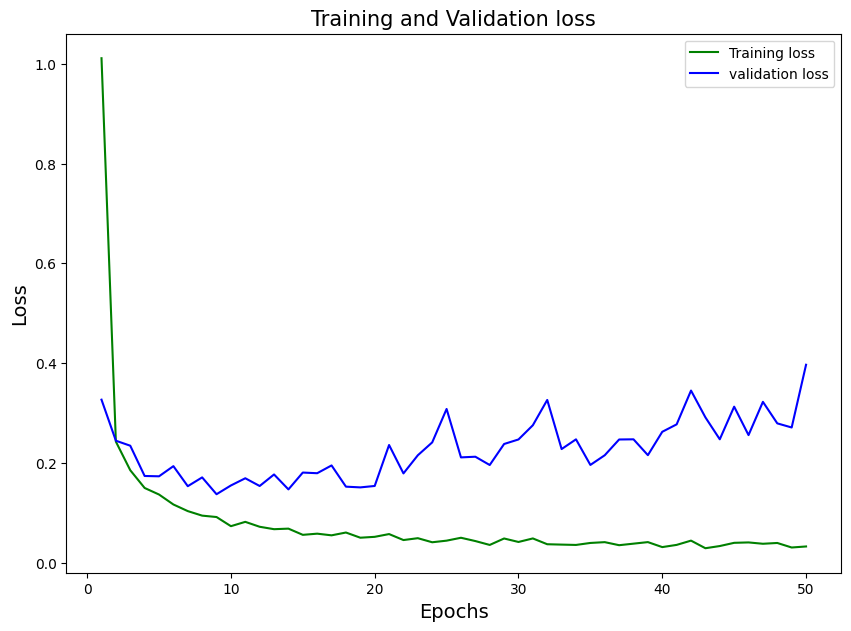

In [ ]:
loss_train = history_3.history['loss']
loss_val = history_3.history['val_loss']

epochs = range(1,n_epocas_3+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend()
plt.show()

**Grafica Accuracy**

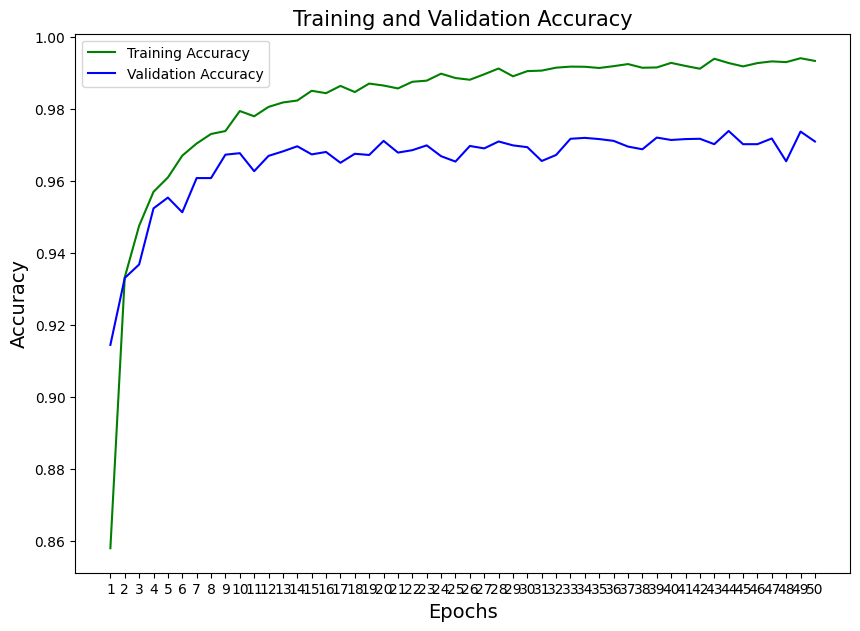

In [ ]:
loss_train = history_3.history['accuracy']
loss_val = history_3.history['val_accuracy']

epochs = range(1,n_epocas_3+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xticks(epochs)
plt.legend()
plt.show()

In [ ]:
predictions_matrix = model_3.predict(X_test)
predictions = np.argmax(predictions_matrix, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Test Accuracy: {accuracy_score(y_pred=predictions,y_true=y_test_original)}")
print(f"Test Recall: {recall_score(y_pred=predictions,y_true=y_test_original,average='macro')}")
print(f"Test Precision: {precision_score(y_pred=predictions,y_true=y_test_original,average='macro')}")

Test Accuracy: 0.9694
Test Recall: 0.9691114061652358
Test Precision: 0.969365951126966


**Cambios**

Epoch 1/50
938/938 [==============================] - 25s 23ms/step - loss: 2.2454 - accuracy: 0.8040 - val_loss: 0.2702 - val_accuracy: 0.9261
Epoch 2/50
938/938 [==============================] - 12s 13ms/step - loss: 0.3674 - accuracy: 0.9010 - val_loss: 0.1807 - val_accuracy: 0.9552
Epoch 3/50
938/938 [==============================] - 13s 14ms/step - loss: 0.2709 - accuracy: 0.9266 - val_loss: 0.1567 - val_accuracy: 0.9584
Epoch 4/50
938/938 [==============================] - 12s 13ms/step - loss: 0.2271 - accuracy: 0.9378 - val_loss: 0.1401 - val_accuracy: 0.9625
Epoch 5/50
938/938 [==============================] - 12s 13ms/step - loss: 0.2024 - accuracy: 0.9454 - val_loss: 0.1435 - val_accuracy: 0.9652
Epoch 6/50
938/938 [==============================] - 12s 13ms/step - loss: 0.1880 - accuracy: 0.9499 - val_loss: 0.1233 - val_accuracy: 0.9666
Epoch 7/50
938/938 [==============================] - 11s 12ms/step - loss: 0.1720 - accuracy: 0.9544 - val_loss: 0.1364 - val_accuracy:

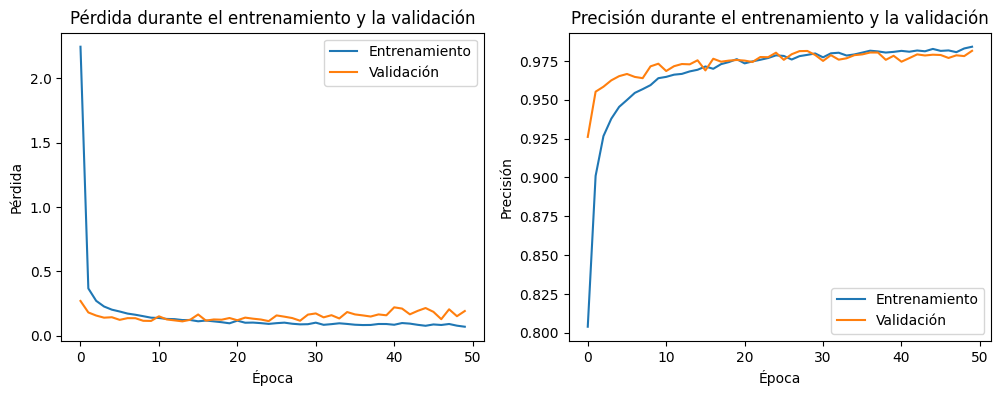

In [ ]:
import numpy as np
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Cargar el conjunto de datos MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Codificar las etiquetas en formato one-hot
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Guardar las etiquetas originales para las métricas de sklearn
y_test_original = np.argmax(y_test, axis=1)

# Definir el modelo con ajustes de hiperparámetros
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))

# Añadir más capas ocultas con diferente número de neuronas y funciones de activación
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))  # Añadir Dropout para evitar overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(10, activation='softmax'))

# Probar con otro optimizador, como Adam
optimizer = Adam()

# Compilar el modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

# Calcular las métricas usando sklearn
test_accuracy = accuracy_score(y_test_original, predictions)
test_recall = recall_score(y_test_original, predictions, average='macro')
test_precision = precision_score(y_test_original, predictions, average='macro')

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")

# Graficar pérdida y precisión
plt.figure(figsize=(12, 4))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()


El Dropout es una técnica efectiva para mejorar la robustez y la capacidad de generalización de las redes neuronales al reducir el riesgo de sobreajuste. Es especialmente útil en redes profundas y cuando se dispone de grandes conjuntos de datos.

En este ejemplo, el Dropout se aplica después de las capas densas con una tasa de 0.2, lo que significa que el 20% de las neuronas se apagarán aleatoriamente en cada paso de entrenamiento.





